In [27]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Reinventing neural networks

(Intentionally reinventing the wheel)

I wanted to try to derive the ideas of machine learning for myself. I do have some knowledge (so it's not completely independent of course), but I want to try to derive a lot of the ideas myself.

The first sample problem is to write a machine learning algorithm to learn the xor function.

So here's the xor logic table:

| x0 | x1 | y |
|----|----|---|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 0  | 1 |
| 1  | 1  | 0 |

So we have a 2 input function that returns 1 value - something like this:

<img src="images/xor_network1.png"  style="width: 50%; height: 50%" />

My initial thought is that we can convolute through some linear model, and adjust coefficients to get the right answer.

So the equation would look something like this:

$W0*x0 + W1*x1 = y$

You could put this into matrix form and add a bias coefficient, in which case it would look like this:

$Ax +b = y$ where A is the vector containing the 2 weights, x is a free variable to hold the features - x0 and x1, and y is the vector of labels) - so something like this:

<img src="images/xor_matrix_form1.png" style="width: 50%; height: 50%" />

Before trying to write an algorithm to optimize the values of W0 and W1, let's first make sure this model is powerful enough to work for the xor function. After thinking for a minute, I was able to determine that the values W0 = 1 and W2 = -1 would be good values, since if we plug those weights into the equation, $W0*x0 + W1*x1 = y$, we get $1*x0 + -1*x1$, and that should come out to the values of y (or at least, the value should be > 0.5 for (0, 1) and (1, 0), and < 0.5 for (0, 0) and (1, 1) ). And it turns out, that works:
* for x0=0 and x1=1: `1*0 + -1*0 = 0`
* for x0=0 and x1=1: `1*0 + -1*1 = -1`
* for x0=0 and x1=1: `1*1 + -1*0 = 1`
* for x0=0 and x1=1: `1*0 + -1*0 = 0`

Shoot - when I first ran the numbers in my head, I was thinking the 2nd equation came out to 1, not -1. And actually, graphing it out, xor would look like this:

<img src="images/xor_graph.png"  style="width: 400px; height: 400px;" />

And as you can clearly see, that is not linearly separable. That is why, when I tried a linear classifier, it didn't work:

In [2]:
# Note that I'm making 10x repetitions of the logic table.
X = [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]]*10
y = [0, 1, 1, 0]*10

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y)

[clf.predict([sample]) for sample in [(0, 0), (0, 1), (1, 0), (1, 1)]]

[array([0]), array([0]), array([0]), array([0])]

This is wrong - presumably because a linear model simply isn't powerful enough, whereas something like RandomForest is:

In [3]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)

[clf.predict([sample]) for sample in [(0, 0), (0, 1), (1, 0), (1, 1)]]

[array([0]), array([1]), array([1]), array([0])]

So RandomForest clearly works, but linear models do not. So we need to add some power to our model. How can we change it to be more powerful? Some ideas that come to mind:

* Move from a linear to a polynomial model.
* Add another layer to the network.

Would these work? Is it possible that adding layers is similar in function to adding polynomials?

Let's go with adding a layer...

So the very simplest layer I could think of would be this:

<img src="images/xor_network2.png"  style="width: 50%; height: 50%;" />
(note: weights should be w0, w1, w2, and w3)

But I know that typically, when I've seen pictures of neural networks, the inputs from one layer go to each of the nodes in the next layer - more like this:

<img src="images/xor_network3.png"  style="width: 50%; height: 50%;" />
(note: weights should be w0, w1, w2, and w3)

I think the reason for this is that, in the prior network (without the cross in the middle), the 2 layers of weights are still only being added to the same input, which is really functionally the same as just having 1 layer. So I'm going to test out the network with the cross.

So now we have 4 weights to play with. Let's see if I could imagine a solution where the weights are adjusted so that xor works... on second thought, that sounds like a good job for a program - let's do it that way.

### Finding weights programmatically

A few initial thoughts on writing a program to learn:
* The inputs for the second layer are not the inputs, but the outputs of the previous layer.
* We probably can't just keep 4 variables (one for each weight we are trying to tune), because we might optimize for the first sample, and then reoptimize for the second, and third, and so forth. One solution would be to generate a number of hypotheses for the weights, and keep them all in memory, and then find the one that minimizes error for all samples. Later, we can try to actually tweak the weights.

So let's try to write this. First, some helper functions...

In [4]:
import random

def rand_weight(weight_min, weight_max):
    """Generates a uniformly random weight between weight_min and weight_max."""
    return random.random() * (weight_max - weight_min) + weight_min

def gen_hypothesis(weight_min, weight_max, num_weights):
    return tuple([rand_weight(weight_min, weight_max) for i in range(num_weights)])
        

In [5]:
rand_weight(0, 10)

7.706551715382767

In [6]:
gen_hypothesis(-5, 5, 4)

(-4.814122290019785,
 1.4739675581934826,
 -4.116735204818674,
 -3.690855764792645)

### Node functionality

Next, let's define the functionality of each node. I know there's the concept of an [Activation function](https://en.wikipedia.org/wiki/Activation_function) in common neural network terminology. I suppose there are several ways a given node could function:
* It could always output some discrete value (like 1 and 0, or -1 and 1).
* It could output a continuous value bounded within some range like a probability (e.g. 0 to 1).
* It could output an unbounded continuous value.

For starters, I'm going to just go with what seems the simplest - it's just going to output an unbounded continuous value taking by multiplying the input by the weight. So the equation to determine the output of a given node will be: $node(x) = w0 * x$.

On second thought, though... now that we have a hidden layer, those nodes will have more than one input. So how should that be handled? It could be handled a few ways:
* We could make each input have its own weight.
* We could use the same weight for all of the inputs.

I'm again going to choose the dumbest easiest approach and say each node only has a single weight (even though, if I recall correctly, neural networks typically have different weights for each input - but we'll get there eventually). And if there is more than 1 sample, we'll just add them all together.

## Attempt 1

In [7]:
class Node:
    def __init__(self, weight):
        self.weight = weight
    def run(self, node_input):
        if type(node_input) != list:
            node_input = [node_input]
        return sum([self.weight * input_val for input_val in node_input])

Let's test the node implementation...

In [8]:
n = Node(10)
[n.run([1]), n.run([5]), n.run([1, 2, 3])]

[10, 50, 60]

Looks good. Now let's try to write the network.

Actually, just trying to write this, I immediately realize that we need to do some sort of convolution at the output node (to join its 2 inputs), so let's just add a 5th weight for that node.

In [9]:
def neural_net_1(weights, sample):
    input_layer = [Node(weights[0]), Node(weights[1])]
    hidden_layer = [Node(weights[3]), Node(weights[2])]
    output_layer = Node(weights[4])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    output_layer_output = output_layer.run(hidden_layer_output)
    
    return output_layer_output

Let's test that...

In [10]:
neural_net_1([0, 0, 0, 0, 0], [1, 1, 1, 1, 1])

0

In [11]:
neural_net_1([1, 1, 1, 1, 1], [1, 1, 1, 1, 1])

4

In [12]:
# Should double the above
neural_net_1([1, 1, 1, 1, 2], [1, 1, 1, 1, 1])

8

In [13]:
neural_net_1([2, 2, 2, 2, 2], [10, 10, 10, 10, 10])

320

Seems to work as expected. Let's now write an algorithm to generate a bunch of weight hypotheses, and choose the best one.

In [14]:
class NeuralNetPredictor:
    def __init__(self, num_hypotheses=1000, weight_min=-5, weight_max=5):
        # generate hypotheses randomly
        self.hypotheses = [gen_hypothesis(weight_min, weight_max, 5) for i in range(num_hypotheses)]
        self.hypothesis_to_error = {h: 0 for h in self.hypotheses}
        self.trained_weights = [0]*5
    
    def add_sample(self, sample, expected_value):
        for h in self.hypotheses:
            network_value = neural_net_1(h, sample)
            # print('sample = {}, network_value = {}'.format(sample, network_value))
            err = (network_value - expected_value)**2
            self.hypothesis_to_error[h] += err
    
    def train(self, samples, labels):
        for index in range(len(samples)):
            self.add_sample(samples[index], labels[index])
        
        # Find hypothesis with lowest error
        best_hypothesis = self.hypotheses[0]
        lowest_err = 10000000
        for hyp_index in range(len(self.hypotheses)):
            hyp = self.hypotheses[hyp_index]
            err = self.hypothesis_to_error[hyp]
            if err < lowest_err:
                lowest_err = err
                best_hypothesis = hyp
        
        self.trained_weights = best_hypothesis
        print('Best hypothesis weights: {}'.format(best_hypothesis))
 
    def predict(self, sample):
        return neural_net_1(self.trained_weights, sample)

In [15]:
# Note that I'm making 10x repetitions of the logic table.
X = [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]]*10
y = [0, 1, 1, 0]*10

xor_predictor = NeuralNetPredictor()
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (-4.835723019141343, -2.151626509195678, -2.5743759790844845, 2.6450847102501864, -1.304615234513605)
Predictions: [0.0, 0.19848257068022424, 0.4460842678014316, 0.644566838481655]


In [16]:
xor_predictor = NeuralNetPredictor()
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (1.2691361815047593, 1.323306590493453, 4.080570405796291, -4.129541464772575, -4.301876441138667)
Predictions: [0.0, 0.278777618248764, 0.2673656765975103, 0.5461432948462743]


In [17]:
xor_predictor = NeuralNetPredictor()
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (1.4182072209952157, 2.994979664378551, -1.7268446644494349, 3.033152215017221, 0.08999821095586835)
Predictions: [0.0, 0.3521058100508829, 0.1667320176853846, 0.5188378277362674]


### It doesn't work!

Okay, so this is clearly not working. At this point, we're not using converting into classes based on the output value, but still, I'd expect the output values to be higher at (0, 1) and (1, 0). But instead, it seems like they pretty much correspond to the input values (1, 1) is almost always the highest, (0, 0) is always 0, and (0, 1) and (1, 0) are almost always about half of (1, 1). Interestingly, the 4 classes summed together is very near 1 - which is kind of surprising considering I'm not explicitly doing any probability normalizations.

So why is this not working? My guess is that, since the "expected value" used to calculate the error with is always either 0 or 1, it's being almost entirely factored out by large network output values. So to fix this, we'd probably want the network values to be something in the 0 to 1 range (to match the classes).

Well, we'll try that another day.

## Normalize neuronal output (fix attempt #1)

In the previous attempt, the output power of a neuron was proportional to the magnitude of it's input. But from doing a bit of research on [Neural action potentials](https://en.wikipedia.org/wiki/Action_potential), it seems like the output of a neuron should not be proportinal to the input:

> "The amplitude of an action potential is independent of the amount of current that produced it. In other words, larger currents do not create larger action potentials. Therefore, action potentials are said to be all-or-none signals, since either they occur fully or they do not occur at all." (https://en.wikipedia.org/wiki/Action_potential#%22All-or-none%22_principle)

So, let's try that...

The first question is, what is it outputing? The first thought I have is "0 or 1". Seems simple enough. But how can I determine if it should be 0 or 1? My first thought is the [sigmod function](https://en.wikipedia.org/wiki/Sigmoid_function), which converts from real numbers to a number between 0 and 1, f(x) = 0.5. This would basically then just convert from [-infinity, 0] -> 0 and [0, +infinity] -> 1, assuming 0.5 is considered the threshold for "high". That's not very useful unless we can either:
* Shift the sigmoid function to the left or right
* Change the threshold used to count as "1"/high.

Both of these are possible, and these could both be used as parameters which can be learned. A few more thoughts:
* If the output of a neuron is normalized to 1, the more input neurons there are, the more the sigmoid function would be shifted to the right. In other words, the shift to the right should be linearly proportional to the number of input neurons.
* Another option... would be to move from the output of the neuron being "0 or 1" to "-1 or 1"... That would allow the sigmoid function to be centered on 0 without biasing against firing... maybe that's a good idea. That way, we could only learn the threshold, rather than having to worry about optimizing both the shift/bias and the thresold.

Doing a quick search, it appears the sigmoid function is a good activation function - almost all activation functions on wikipedia have that shape: https://en.wikipedia.org/wiki/Activation_function. So that's a good sign.

I'm now leaning toward the -1, 1 outputs for the neuron after looking at the activation potential of neurons, which appears to vary between negative and positive voltages:

<img src="images/neuron_activation_potential.png" style="width: 40%; height: 40%" />

## Sigmoid function

Let's try playing with the sigmoid function a bit.

In [18]:
import math
import numpy as np

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [19]:
sigmoid(0)

0.5

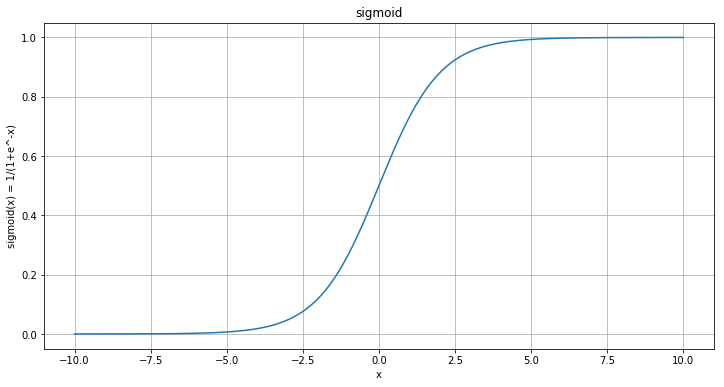

In [26]:
x = np.linspace(-10, 10, 1000)
y = [sigmoid(i) for i in x]
setup_graph(title='sigmoid', x_label='x', y_label='sigmoid(x) = 1/(1+e^-x)', fig_size=(12,6))
plt.grid(True)
plt.plot(x, y)
plt.show()

Just looking at this, it appears that shifting left and right would be functionally equivalent to lowering/raising the "activation threhsold". Another thing that could be useful, potentially, is to spread out the graph horizontally... but let's not worry about that for now.

So, we now have an activation function for each "neuron". So what knobs do we now have which can be learned?
* Activation threshold - some value betweeen 0 and 1. This will be applied to the output of the sigmoid function, which itself has as inputs the summation of the values of all the input neurons, each of which will either be -1 or 1.
* The weights applied to each input neuron.

But let's see... do we really need the weights? Can we just tweak the activation threshold / bias? If we did this, then we would still use linear convolution - it would just be a linear convolution where every coefficient is 1 and there is no bias.
* Side question: how does nature tweak activation threshold? Or maybe it has some other way of "learning"?

Let's try to implement this idea - **each neuron has an activation threshold / bias, and those are the values that are learned.**

First, let's see if we can tweak the activation threshold/bias of the sigmoid. We should be able to move it up/down by doing f(x) -> f(x - bias)...

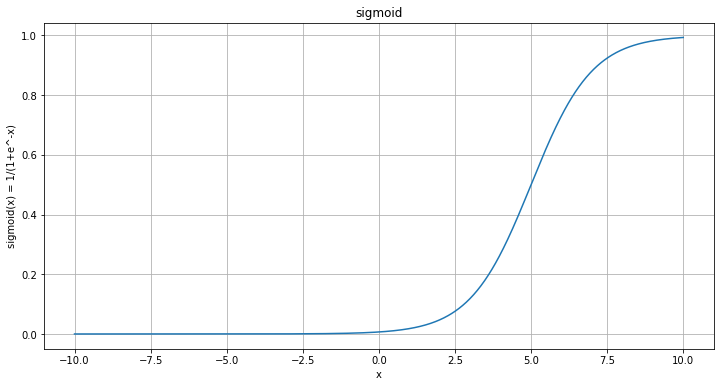

In [30]:
def show_sigmoid(bias):
    x = np.linspace(-10, 10, 1000)
    y = [sigmoid(i - bias) for i in x]

    setup_graph(title='sigmoid', x_label='x', y_label='sigmoid(x) = 1/(1+e^-x)', fig_size=(12,6))
    plt.grid(True)
    plt.plot(x, y)
    plt.show()

show_sigmoid(5)

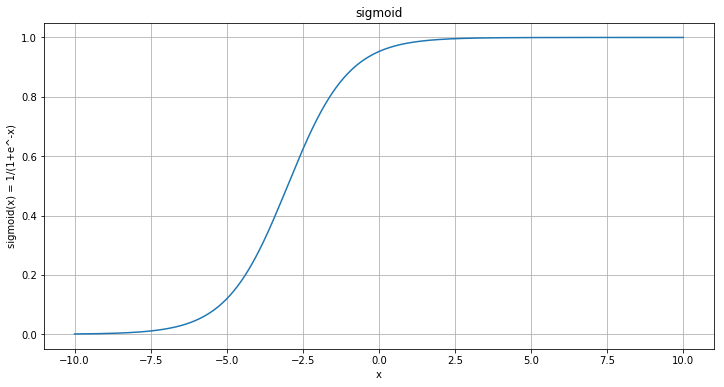

In [31]:
show_sigmoid(-3)

Something that just occurred to me is that, if the output of our neuron is all or nothing, the sigmoid/bias is kind of the same as an if statement like `if input > bias: 1; else: -1`. So actually, to simplify even further, let's try to just use an if statement and tweak the "activation_threshold".

In [34]:
class Neuron:
    def __init__(self, activation_threshold):
        self.activation_threshold = activation_threshold
        
    def run(self, node_input):
        if type(node_input) != list:
            node_input = [node_input]
        input_sum = sum(node_input)
        if input_sum >= self.activation_threshold:
            return 1
        else:
            return -1

In [38]:
Neuron(0).run([2])

1

In [37]:
Neuron(0).run([-10])

-1

In [39]:
Neuron(5).run([2, 2])

-1

In [40]:
Neuron(5).run([2, 3])

1

Cool - hard to get any simpler than this. Let's go back and try to implement that same neural network to predict xor...

## Attempt 2

Here's the network again:

<img src="images/xor_network3.png"  style="width: 50%; height: 50%;" />
(note: weights should be w0, w1, w2, and w3)

In [43]:
def neural_net_2(thresholds, sample):
    input_layer = [Neuron(thresholds[0]), Neuron(thresholds[1])]
    hidden_layer = [Neuron(thresholds[3]), Neuron(thresholds[2])]
    output_layer = Neuron(thresholds[4])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    output_layer_output = output_layer.run(hidden_layer_output)
    
    return output_layer_output

Except these are not really weights, but activation thresholds now. So let's see, if the last activation `theresholds[4]` is really high, the output should always be -1. Let's use this as a rough smoke test:

In [44]:
neural_net_2([0, 0, 0, 0, 100], [1, 1])

-1

And if it's really low, the output should typically be high:

In [45]:
neural_net_2([0, 0, 0, 0, -100], [1, 1])

1

Good enough for me. Let's try to write a trainer for this.

Again (for anyone reading this), I understand this is a HORRIBLE training algorithm - this is really just a test of the neurons, rather than the training algorithm itself. Randomly generating solutions is about as unsophisticated of a training algorithm possible.

In [54]:
class NeuralNetTrainer2:
    def __init__(self, neural_net_func, num_hypotheses=1000, threshold_min=-5, threshold_max=5):
        # generate hypotheses randomly
        self.neural_net_func = neural_net_func
        self.hypotheses = [gen_hypothesis(threshold_min, threshold_max, 5) for i in range(num_hypotheses)]
        self.hypothesis_to_error = {h: 0 for h in self.hypotheses}
        
        # Trained weights (start at 0) - almost certainly bad until train()'ed
        self.trained_thresholds = [0]*5
    
    def add_sample(self, sample, expected_value):
        for h in self.hypotheses:
            network_value = self.neural_net_func(h, sample)
            # print('sample = {}, network_value = {}'.format(sample, network_value))
            err = (network_value - expected_value)**2
            self.hypothesis_to_error[h] += err
    
    def train(self, samples, labels):
        for index in range(len(samples)):
            self.add_sample(samples[index], labels[index])
        
        # Find hypothesis with lowest error
        best_hypothesis = self.hypotheses[0]
        lowest_err = 10000000
        for hyp_index in range(len(self.hypotheses)):
            hyp = self.hypotheses[hyp_index]
            err = self.hypothesis_to_error[hyp]
            if err < lowest_err:
                lowest_err = err
                best_hypothesis = hyp
        
        self.trained_thresholds = best_hypothesis
        print('Best hypothesis weights: {}'.format(best_hypothesis))
 
    def predict(self, sample):
        return self.neural_net_func(self.trained_thresholds, sample)

In [48]:
# Note that I'm making 10x repetitions of the logic table.
X = [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]]*10
y = [0, 1, 1, 0]*10

xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (2.628474400738364, 1.6115061304711347, -3.376169418044711, 0.6379000877486787, -2.477611910124832)
Predictions: [1, 1, 1, 1]


In [49]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (-3.2496744299729166, 3.7513463957571833, -3.3266980137764266, -3.732550991505741, -1.33243859281965)
Predictions: [1, 1, 1, 1]


In [50]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (-3.5403862816578924, -1.1822749503866978, 4.640251643184293, 0.1592391231822976, -3.072080465005642)
Predictions: [1, 1, 1, 1]


In [55]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (3.1295257393348646, -0.37632723552326475, -4.796511229256844, -2.40702164572675, 0.01356449634245216)
Predictions: [1, 1, 1, 1]


**Fail.** This is worse than before, since it seems to simply optimize for all 1 outputs, and the weights seem random. Why is this?

What if the error function is not very good because we are squaring the error, but the outputs are only either -1 and 1, so squaring 1 yields 1.... What if we make the outputs larger, like -2 and 2?

In [56]:
class Neuron:
    def __init__(self, activation_threshold):
        self.activation_threshold = activation_threshold
        
    def run(self, node_input):
        if type(node_input) != list:
            node_input = [node_input]
        input_sum = sum(node_input)
        if input_sum >= self.activation_threshold:
            return 2
        else:
            return -2

In [57]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (-4.511982182951603, -2.899993434942789, 0.7201391932610992, -2.085998381590317, 3.6520963844805543)
Predictions: [2, 2, 2, 2]


In [58]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (1.986396944139858, -3.6853876056797654, -1.3335861094167711, -1.9123963309692336, -3.7480456787143765)
Predictions: [2, 2, 2, 2]


Nope, that doesn't work...

In [59]:
xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2, threshold_min=-10, threshold_max=10)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Best hypothesis weights: (-6.808625433333447, 9.289828019609999, 5.139754493308875, -1.0013509162198169, -0.005776643552195537)
Predictions: [2, 2, 2, 2]


Ohhhh.... I know. It's because the labels are 0, but the output is -1 and 1, which are equidistant from 0. So maybe it will work if I use -1 in place of 0 in the labels.

In [87]:
class Neuron:
    def __init__(self, activation_threshold):
        self.activation_threshold = activation_threshold
        
    def run(self, node_input):
        if type(node_input) != list:
            node_input = [node_input]
        input_sum = sum(node_input)
        if input_sum >= self.activation_threshold:
            return 1
        else:
            return -1

In [94]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*10
y = [-1, 1, 1, -1]*10

xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (0.45280500411716584, 0.08621623715362503, -3.4129747425502677, -0.8432143671732248, 1.1255942985130822)
Predictions: [-1, 1, 1, 1]


Well, that isn't correct, but at least it seems to be converting to a prediction of `[-1, 1, 1, 1]`. But why? Is it possible there aren't enough neurons to learn xor? What if I try to learn "or" or "and"?

### Attempt at learning "or"

In [95]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*10
y = [-1, 1, 1, 1]*10

xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-0.2722838143109021, -0.7997278386441176, -2.5337467766377255, -1.2030666543714617, 1.3147527484451)
Predictions: [-1, 1, 1, 1]


Hey, that worked! What about "and"?

### Attempt at learning "and"

In [96]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*10
y = [-1, -1, -1, 1]*10

xor_predictor = NeuralNetTrainer2(neural_net_func=neural_net_2, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (0.32724388633882473, -0.17305249315130844, 1.6592034742259933, -3.533461005859518, 0.9445998582037527)
Predictions: [-1, -1, -1, 1]


Sweet, that works too! So I think I don't have enough neurons to learn "xor". Let's see if I build a larger neural network. Let's try just adding one more neuron in the hidden layer...

## Attempt 3

In [97]:
def neural_net_3(thresholds, sample):
    input_layer = [Neuron(thresholds[0]), Neuron(thresholds[1])]
    hidden_layer = [Neuron(thresholds[2]), Neuron(thresholds[3]), Neuron(thresholds[4])]
    output_layer = Neuron(thresholds[5])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    output_layer_output = output_layer.run(hidden_layer_output)
    
    return output_layer_output

In [108]:
# Obviously, I'll want abstract this code at some point

class StocasticNeuralNetTrainer:
    def __init__(self, neural_net_func, num_knobs, num_hypotheses=1000, threshold_min=-5, threshold_max=5):
        self.neural_net_func = neural_net_func
        
        # generate hypotheses randomly
        self.hypotheses = [gen_hypothesis(threshold_min, threshold_max, num_knobs) for i in range(num_hypotheses)]
        self.hypothesis_to_error = {h: 0 for h in self.hypotheses}
        
        # Trained weights (start at 0) - almost certainly bad until train()'ed
        self.trained_thresholds = [0]*num_knobs
    
    def add_sample(self, sample, expected_value):
        for h in self.hypotheses:
            network_value = self.neural_net_func(h, sample)
            # print('sample = {}, network_value = {}'.format(sample, network_value))
            err = (network_value - expected_value)**2
            self.hypothesis_to_error[h] += err
    
    def train(self, samples, labels):
        for index in range(len(samples)):
            self.add_sample(samples[index], labels[index])
        
        # Find hypothesis with lowest error
        best_hypothesis = self.hypotheses[0]
        lowest_err = 10000000
        for hyp_index in range(len(self.hypotheses)):
            hyp = self.hypotheses[hyp_index]
            err = self.hypothesis_to_error[hyp]
            if err < lowest_err:
                lowest_err = err
                best_hypothesis = hyp
        
        self.trained_thresholds = best_hypothesis
        print('Best hypothesis weights: {}'.format(best_hypothesis))
 
    def predict(self, sample):
        return self.neural_net_func(self.trained_thresholds, sample)

In [109]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*10
y = [-1, 1, 1, -1]*10

xor_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_3, num_knobs=6, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-0.9375573492773412, 0.022234681214007068, -0.838957933413754, -4.1290886314422295, -1.9360330302674509, -0.4437439094198954)
Predictions: [-1, 1, 1, 1]


Nope, let's try two more neurons in the hidden layer...

In [112]:
def neural_net_4(thresholds, sample):
    input_layer = [Neuron(thresholds[0]), Neuron(thresholds[1])]
    hidden_layer = [Neuron(thresholds[2]), Neuron(thresholds[3]),
                    Neuron(thresholds[4]), Neuron(thresholds[5]), Neuron(thresholds[6])]
    output_layer = Neuron(thresholds[7])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    output_layer_output = output_layer.run(hidden_layer_output)
    
    return output_layer_output

In [113]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*20
y = [-1, 1, 1, -1]*20

xor_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_4, num_knobs=8, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-0.11109716802769576, 0.516490214968556, -0.8042769067565558, 0.3641258617735712, 2.6256869204799003, 4.09896880704998, -0.7847015406797215, -2.8096838306238547)
Predictions: [-1, 1, 1, 1]


Still no good - it appears that this neural network is still unable to learn anything but linearly seperable distinctions. Somehow, adding more neurons in this single hidden layer is NOT adding any robustness. My guess is that adding all these neurons together is functionally equivalent to one weighted neuron.  What if I add another hidden layer?

## Attempt 4

In [137]:
def neural_net_5(thresholds, sample):
    input_layer = [Neuron(thresholds[0]), Neuron(thresholds[1])]
    hidden_layer = [Neuron(thresholds[2]), Neuron(thresholds[3]), Neuron(thresholds[4])]
    hidden_layer2 = [Neuron(thresholds[5]), Neuron(thresholds[6]), Neuron(thresholds[7])]
    output_layer = Neuron(thresholds[8])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    hidden_layer_output2 = [hidden_layer2[i].run(hidden_layer_output) for i in range(len(hidden_layer2))]
    output_layer_output = output_layer.run(hidden_layer_output2)
    
    return output_layer_output

In [139]:
# Note that I'm making 10x repetitions of the logic table.
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]*10
y = [-1, 1, 1, -1]*10

xor_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_5, num_knobs=9, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-0.17513285385608057, 0.7013863554966111, -1.883921911037747, -1.1442650414639957, 1.2597020311777927, -2.380533761310245, 2.4687002726034146, 1.0737061167811195, -2.046070414233988)
Predictions: [-1, 1, 1, 1]


Still not working. Here's a few possible ideas to fix it:
* Add weights for each neuron input
* Add multiple output neurons - one for each class.

Let's try adding weights to each neuron input...

## Attempt 5

In [140]:
class Neuron:
    def __init__(self, activation_threshold, input_weights):
        self.activation_threshold = activation_threshold
        self.input_weights = input_weights
        
    def run(self, node_input):
        if type(node_input) != list:
            node_input = [node_input]
        input_sum = sum([node_input[i]*self.input_weights[i] for i in range(len(self.input_weights))])
        if input_sum >= self.activation_threshold:
            return 1
        else:
            return -1

In [141]:
Neuron(100, [50]).run(2)

1

In [142]:
Neuron(101, [50]).run(2)

-1

In [143]:
Neuron(101, [50, 20, 30]).run([1, 1, 1])

-1

In [144]:
Neuron(100, [50, 20, 30]).run([1, 1, 1])

1

In [155]:
def neural_net_6(knobs, sample):
    # For the input layer, weight inputs to 1, and keep activation at 0
    # Note that this input_layer is functionally nil - it just passes through the sample values, so it
    # could be eliminated. But to keep with the previous examples, let's keep it. Also, it works to just pass
    # the values through since our input values need no conversion. It's possible that some input
    # value would benefit from some sort of conversion (like multiplying by 10 or something).
    input_layer = [Neuron(0, [1]), Neuron(0, [1])]
    hidden_layer = [Neuron(knobs[0], [knobs[1], knobs[2]]),
                    Neuron(knobs[3], [knobs[4], knobs[5]]),
                    Neuron(knobs[6], [knobs[7], knobs[8]])]
    output_layer = Neuron(knobs[9], [knobs[10], knobs[11], knobs[12]])
    
    input_layer_output = [input_layer[i].run(sample[i]) for i in range(len(input_layer))]
    hidden_layer_output = [hidden_layer[i].run(input_layer_output) for i in range(len(hidden_layer))]
    output_layer_output = output_layer.run(hidden_layer_output)
    
    return output_layer_output

In [150]:
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]
y = [-1, 1, 1, -1]

xor_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_6, num_knobs=13, num_hypotheses=10000)
xor_predictor.train(X, y)
print('Predictions: {}'.format([xor_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-3.3312315420723273, -0.6186899538079658, -2.6508818921540267, 2.493483508092309, -0.4926664023882301, -2.581662465372375, 4.409037962549409, 2.7846911252382416, 4.351451406463973, 3.9076180372499234, 0.7566588797370342, -3.4622432181823495, -0.40637788765934246)
Predictions: [-1, 1, 1, -1]


### SUCCESS

**Wow, that works!** Even with a single training set!

So it appears that weighting neuron inputs is extremely important.  Let's verify that it also works for "and" and "or"...

In [151]:
# AND
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]
y = [-1, -1, -1, 1]

and_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_6, num_knobs=13, num_hypotheses=10000)
and_predictor.train(X, y)
print('Predictions: {}'.format([and_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-4.529244947610081, 2.936969444290293, -1.2990161660039643, -1.1425525715508247, -1.1171099453546085, 2.637223421259989, -1.450576551862369, 2.099111039420592, -1.4684208032486898, -0.5733192672310663, -1.2018061387049062, 0.6553881171323823, 0.16330598417973619)
Predictions: [-1, -1, -1, 1]


In [152]:
# OR
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]
y = [-1, 1, 1, 1]

or_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_6, num_knobs=13, num_hypotheses=10000)
or_predictor.train(X, y)
print('Predictions: {}'.format([or_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-3.1605694002727445, 3.3801485891287033, -1.6049544308097783, -3.5303776982494615, -3.075839726860643, -1.5574362967649593, -2.6872142597094806, 3.5848938828733186, 2.1433849729883754, -1.703647433794182, -0.2625786694309795, 0.4854661813110184, 3.0861353218611924)
Predictions: [-1, 1, 1, 1]


In [153]:
# NAND
X = [[-1, -1],
     [-1, 1],
     [1, -1],
     [1, 1]]
y = [1, 1, 1, -1]

nand_predictor = StocasticNeuralNetTrainer(neural_net_func=neural_net_6, num_knobs=13, num_hypotheses=10000)
nand_predictor.train(X, y)
print('Predictions: {}'.format([nand_predictor.predict(x) for x in [(-1, -1), (-1, 1), (1, -1), (1, 1)]]))

Best hypothesis weights: (-0.533528739179701, -0.7368093945337026, -1.8028438243444977, 4.250712610532435, 1.7505676222829827, 4.7405926648756065, 1.5256770444732783, -4.860280343429942, -4.473899186181715, -2.413998309817739, 0.720939834638723, -1.4772823865981177, 2.483843316813747)
Predictions: [1, 1, 1, -1]


## Conclusion

So this works very well. Why are weighted neuron inputs so important? I think that without weights, each input neuron is equally important, which cuts flexibility.

Next steps
* How can we actually train the network (without just generating random hypotheses)?
    - Up to this point, we're just generating random configurations of knobs and picking the best configuration. The next step is to write an algorithm to adjust the knobs.
* How could we do multi-class classifiers? (probably with multiple output neurons)
* How does this behave with probabilistic relationships between inputs and outputs? (in these boolean logic functions, there is 100% correlation between inputs and outputs)

Questions
* Does nature have the concept of weighted neuron inputs? If so, how is it implemented in nature?
* Brains run on bayesian probability - how can I incorporate bayesian probability into my neural network model?
* What is the role of neurotransmitters in reinforcing inputs?
* Can we make the connections between various neurons self-wire (rather than hardcoding them)? Can the labels be just another input?